In [63]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from lmfit import Parameters, Minimizer
from scipy.interpolate import griddata
from model_functions import gaussian_model, get_err_lsq, build_normal_volsurface
from basic_functions import fwd_swap_rate, swaption
display(HTML("<style>.container {width:95% !important;}</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gaussian two-factor models
Here, we present two implementation of 2-factor gaussian IR models as in (Piterbarg, 2010). Two parametrizations are presented: stanadard and Hull-White (two-factor). General framework is available in the accompanying pdf. accompanying file [IR_gaussian_models.pdf](IR_gaussian_models.pdf)

Full calibration is presented too using real-world market data from either 2018-07-31, or 2019-07-31 EUR swaption market. For fitting, a pacakge _lmfit_ is used.

This jupyter notebook serves as a control interfrace, the key model functions which are called here are implemented in _model_functions.py_ and non-model functions are in _basic_functions.py_.

# 1 Calibration
The calibration is done on ATM swaption data using least squares of model vs market values. This means to estimate (5-tuple) parameter set $\hat \theta$ such that
\begin{equation}
\hat \theta  = \mathop {\arg \min }\limits_\theta  \left[ {\sum\limits_k {{{\left( {{V_k}^\text{model}(\theta ) - V_k^{\text{market}}} \right)}^2}} } \right],
\end{equation}
where 
- $V_k^{\text{market}}$ is value of a $k$th swaption in the calibration set, valued using Bachelier formula for swaptions (using normal volatilities), and
- ${{V_k}^\text{model}(\theta )}$ is $k$th swaption value when valued using the Gaussian 2-factor model and a parameter set $\theta$.

This, implicitly, gives more weight to swaptions of larger values where the square differences are more significant. This could easily be changed by the user (function _get_err_lsq_) such that 
\begin{equation}
\hat \theta  = \mathop {\arg \min }\limits_\theta  \left[ {\sum\limits_k {{{\left( {{\sigma _k}^\text{model}(\theta ) - \sigma _k^\text{market}} \right)}^2}} } \right],
\end{equation}
where 
- ${\sigma _k^\text{market}}$ is the market implied (normal) volatility applicable to $k$th swaption, and
- ${\sigma _k^\text{model}}(\theta)$ is the model implied (normal) volatility applicable to $k$th swaption, given model parameter set $\theta$.

The extra complexity here comes from the fact that ${\sigma _k^\text{model}}(\theta)$ isn't _naturally_ generated by the model but must be computed using a root search algorithm such that
\begin{equation}
\sigma _k^\text{model}(\theta ) = \{ \sigma :V_k^\text{model}(\theta ) - V_k^\text{Bachelier}(\sigma ) = 0\},
\end{equation}
i.e. it is the value of implied volatility that equalizes Gaussian model value and Bacherlier-formula value. Thus, we'd have a root search in minimization.  For optimization package _lmfit_ is used.

## 1.1 Load sample market data for calibration
Market data involves yield curve and normal-volatility ATM volsurface where swaption underlyings are semiannual EUR swaps. _Normal_ because EUR rates are negative so lognormal model (and its volatilities) can't be used. We only select volatilities that are for quotes with tenor $\ge 1$ and expiry $\ge 1$ to rule out some extreme volatilities for short expiries/tenors.

In [36]:
ycrv = pd.read_csv('IR_curve_EUR_2019_07_31.csv')
vols = pd.read_csv('normal_volsurface_2019_07_31.csv')

vols = vols.rename(columns = {'expiry/tenor':'expiry'}).set_index('expiry').rename_axis('tenor', axis = 1)
vols = vols.stack().reset_index().rename(columns = {0:'sigma_normal'})
vols['tenor'] = vols['tenor'].astype(float) 
vols['TN'] = vols.eval('expiry+tenor')
vols = vols.query('expiry >=1 and tenor >=1').rename(columns = {'expiry':'T0'})
vols = vols[['T0', 'TN', 'tenor', 'sigma_normal']]

## 1.2 Standard model parametrization: calibration
In the standard parametrization we have a 5-tuple parmeter set $({\varkappa _1},{\varkappa _2},{\sigma _1},{\sigma _2},\rho )$. The volatility matrix is then given as
\begin{equation}
\sigma  = \left( {\begin{array}{*{20}{c}}
{{\sigma _{11}}}&{{\sigma _{12}}}\\
{{\sigma _{21}}}&{{\sigma _{22}}}
\end{array}} \right) = \left( {\begin{array}{*{20}{c}}
{{\sigma _1}}&{\rho {\sigma _2}}\\
0&{\sqrt {1 - {\rho ^2}} {\sigma _2}}
\end{array}} \right).
\end{equation}
This defines a $\mathbb{Q}$-dynamics of $x$ as 
\begin{eqnarray}
d{x_1}(t) &=& \left( {{v_1}(t) - {\varkappa _1}{x_1}(t)} \right)dt + {\sigma _{11}}d{W_1}(t) + {\sigma _{21}}d{W_2}(t) = \left( {{v_1}(t) - {\varkappa _1}{x_1}(t)} \right)dt + {\sigma _1}d{W_1}(t)\\
d{x_2}(t) &=& \left( {{v_2}(t) - {\varkappa _2}{x_2}(t)} \right)dt + {\sigma _{12}}d{W_1}(t) + {\sigma _{22}}d{W_2}(t) = \left( {{v_2}(t) - {\varkappa _2}{x_2}(t)} \right)dt + \rho {\sigma _2}d{W_1}(t) + \sqrt {1 - {\rho ^2}} {\sigma _2}d{W_2}(t).
\end{eqnarray}

In [ ]:
params = Parameters()
params.add_many(('kappa1', 0.15,  True, 0.0001, 0.6, None, None),
                ('kappa2', 0.4,  True, 0.0001, 0.6, None, None),
                ('sigma1', 0.05,  True, 0.0001, 0.1, None, None),
                ('sigma2', 0.05, True, 0.0001, 0.1, None, None),
                ('rho',   -0.95,   True,-0.9999,0.9999, None, None))
fitter = Minimizer(lambda params: get_err_lsq(params, vols, 0.5, ycrv['maturity'], ycrv['value'], ycrv_freq = 9999), params = params).minimize(method = 'least_squares')

## 1.3 Standard model parametrization: reconstitution of volsurface
In the example below, a volsurface for ternors $\ge 3y$ and expiries $\ge 5y$ is reconstructed given standard parametrization of a two-factor gaussian model is used.

In [61]:
params_standard = {'kappa1': 0.047942,'kappa2': 0.070179,'sigma1': 0.035285,'sigma2': 0.035644, 'rho': -0.990690}
vols_model = build_normal_volsurface(params_standard, vols['T0'].drop_duplicates(), vols['tenor'].drop_duplicates(), 0.5,ycrv['maturity'], ycrv['value'], ycrv_freq = 9999)

100%|██████████| 225/225 [02:35<00:00,  1.44it/s]


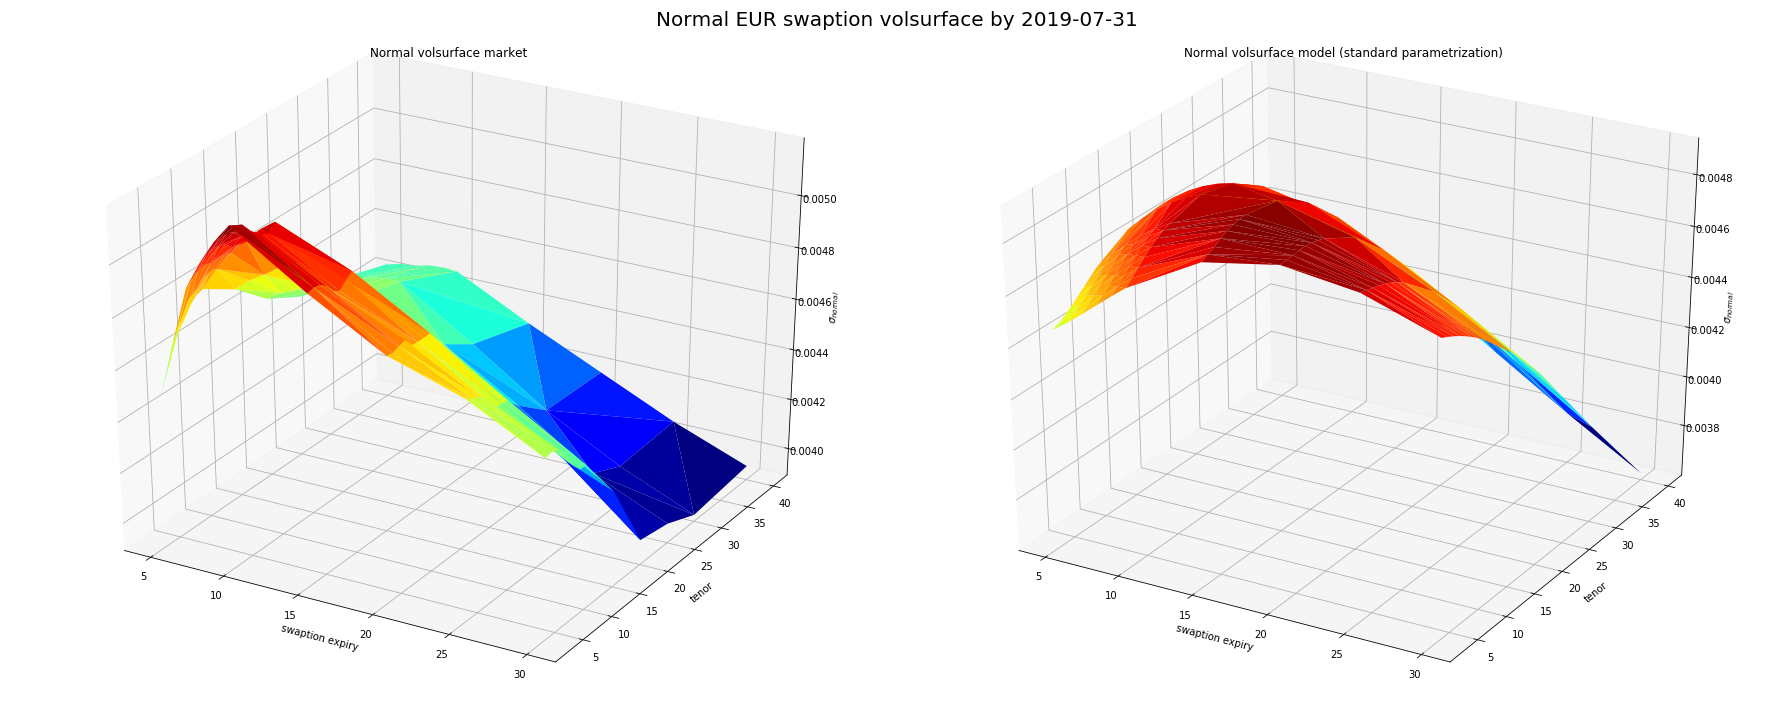

In [35]:
orig_volsurface  = vols.rename(columns = {'T0':'expiry'}).query('expiry>=5 and tenor >= 3')
model_volsurface = vols_model.stack().reset_index().rename(columns = {0:'sigma_normal'}).query('expiry>=5 and tenor >= 3')

fig = plt.figure(figsize = (25, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(orig_volsurface['expiry'],  orig_volsurface['tenor'], orig_volsurface['sigma_normal'], cmap=cm.jet, linewidth=0.2)
ax.set_title('Normal volsurface market')
ax.set_xlabel('swaption expiry')
ax.set_ylabel('tenor')
ax.set_zlabel('$\sigma_{normal}$')
ax  = fig.add_subplot(122, projection='3d')
ax.plot_trisurf(model_volsurface['expiry'], model_volsurface['tenor'], model_volsurface['sigma_normal'], cmap=cm.jet, linewidth=0.2)
ax.set_title('Normal volsurface model (standard parametrization)')
ax.set_xlabel('swaption expiry')
ax.set_ylabel('tenor')
ax.set_zlabel('$\sigma_{normal}$')
fig.suptitle('Normal EUR swaption volsurface by 2019-07-31', fontsize=20)
plt.tight_layout()

## 1.3 Hull-White 2-factor model parametrization
It can be shown that the Hull-White 2-factor is equivalent to a 2-factor gaussian model with a 5-tuple parameter set $({\varkappa _r},{\varkappa _\varepsilon },{\sigma _r},{\sigma _\varepsilon },\rho )$ such that
\begin{equation}
\sigma  = \left( {\begin{array}{*{20}{c}}
{{\sigma _{11}}}&{{\sigma _{12}}}\\
{{\sigma _{21}}}&{{\sigma _{22}}}
\end{array}} \right) = \left( {\begin{array}{*{20}{c}}
{{\sigma _r} - \rho {\sigma _\varepsilon }\frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}&{ - {\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}\\
{\rho {\sigma _\varepsilon }\frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}&{{\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa_r}}}{{{\varkappa_r} - {\varkappa_\varepsilon }}}}
\end{array}} \right)
\end{equation}
This defines a $\mathbb{Q}$-dynamics of $x$ as
\begin{eqnarray}
d{x_1}(t) &=& \left( {{v_1}(t) - {\varkappa _1}{x_1}(t)} \right)dt + {\sigma _{11}}d{W_1}(t) + {\sigma _{21}}d{W_2}(t) = \left( {{v_1}(t) - {\varkappa _r}{x_1}(t)} \right)dt + \left( {{\sigma _r} - \rho {\sigma _\varepsilon }\frac{{{\varkappa _r}}}{{{\varkappa _r} - {\varkappa _\varepsilon }}}} \right)d{W_1}(t) + \rho {\sigma _\varepsilon }\frac{{{\varkappa _r}}}{{{\varkappa _r} - {\varkappa _\varepsilon }}}d{W_2}(t)\\
d{x_2}(t) &=& \left( {{v_2}(t) - {\varkappa _2}{x_2}(t)} \right)dt + {\sigma _{12}}d{W_1}(t) + {\sigma _{22}}d{W_2}(t) = \left( {{v_2}(t) - {\varkappa _\varepsilon }{x_2}(t)} \right)dt - {\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa _r}}}{{{\varkappa _r} - {\varkappa _\varepsilon }}}d{W_1}(t) + {\sigma _\varepsilon }\sqrt {1 - {\rho ^2}} \frac{{{\varkappa _r}}}{{{\varkappa _r} - {\varkappa _\varepsilon }}}d{W_2}(t)
\end{eqnarray}

For completeness, the Hull-White two-factor model that is equivalent to this specification is
\begin{eqnarray}
dr(t) &=& {\varkappa _r}(a(t) + \varepsilon (t) - r(t))dt + {\sigma _r}d{W_r}(t)\\
d\varepsilon (t) &=&  - {\varkappa _\varepsilon }\varepsilon (t)dt + {\sigma _\varepsilon }d{W_\varepsilon }(t),
\end{eqnarray}
where $d{W_r}(t)d{W_\varepsilon }(t) = \rho dt$ and $a$ is a _deterministic_ function of time. This model is also known as doubly mean-reverting model, with stochastic drift.

In [ ]:
params = Parameters()
params.add_many(('kappa_r', 0.15,  True, 0.0001, 0.6, None, None),
                ('kappa_e', 0.4,  True, 0.0001, 0.6, None, None),
                ('sigma_r', 0.05,  True, 0.0001, 0.1, None, None),
                ('sigma_e', 0.05, True, 0.0001, 0.1, None, None),
                ('rho',   -0.95,   True,-0.9999,0.9999, None, None))
fitter = Minimizer(lambda params: get_err_lsq(params, vols, 0.5, ycrv['maturity'], ycrv['value'], ycrv_freq = 9999), params = params).minimize(method = 'least_squares')

## 1.4 Hull-White 2-factor: Reconstitution of volsurface
In the example below, a volsurface for ternors $\ge 3y$ and expiries $\ge 5y$ is reconstructed given Hull-White two-factor parametrization of a two-factor gaussian model is used.

In [62]:
params_HW2F = {'kappa_r': 0.011877,'kappa_e': 0.300907,'sigma_r': 0.074134,'sigma_e': 0.077880, 'rho': -0.699944}
vols_model  = build_normal_volsurface(params_HW2F, vols['T0'].drop_duplicates(), vols['tenor'].drop_duplicates(), 0.5,ycrv['maturity'], ycrv['value'], ycrv_freq = 9999)

100%|██████████| 225/225 [02:32<00:00,  1.47it/s]


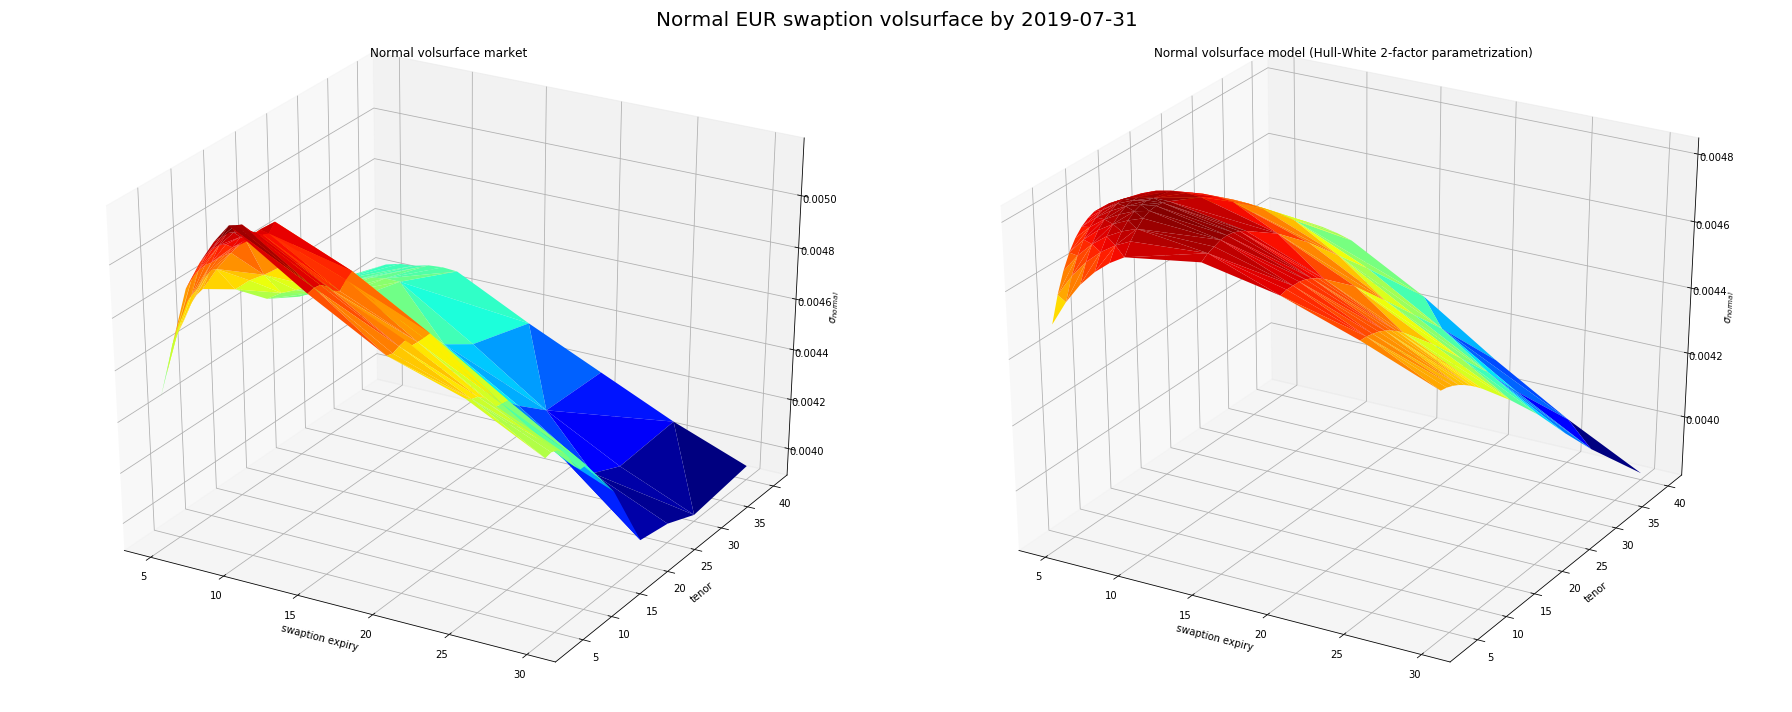

In [40]:
orig_volsurface  = vols.rename(columns = {'T0':'expiry'}).query('expiry>=5 and tenor >= 3')
model_volsurface = vols_model.stack().reset_index().rename(columns = {0:'sigma_normal'}).query('expiry>=5 and tenor >= 3')

fig = plt.figure(figsize = (25, 10))
ax  = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(orig_volsurface['expiry'],  orig_volsurface['tenor'], orig_volsurface['sigma_normal'], cmap=cm.jet, linewidth=0.2)
ax.set_title('Normal volsurface market')
ax.set_xlabel('swaption expiry')
ax.set_ylabel('tenor')
ax.set_zlabel('$\sigma_{normal}$')
ax  = fig.add_subplot(122, projection='3d')
ax.plot_trisurf(model_volsurface['expiry'], model_volsurface['tenor'], model_volsurface['sigma_normal'], cmap=cm.jet, linewidth=0.2)
ax.set_title('Normal volsurface model (Hull-White 2-factor parametrization)')
ax.set_xlabel('swaption expiry')
ax.set_ylabel('tenor')
ax.set_zlabel('$\sigma_{normal}$')
fig.suptitle('Normal EUR swaption volsurface by 2019-07-31', fontsize=20)
plt.tight_layout()

## 2 Valuation of a swaption
As an example of application, here we value a ATM payer swaption that expires at $T_0=5$ years, and is written on 10-year semiannual-coupon IRS (this implies that $T_N = T_0 + 10 = 5+10$ because $T_N$ is the termination time of the underlying IRS). 

We value the swaption within 2-factor gaussian model calibrated under the standard and HW2F formulation, and compare it with analytical price coming from Bachelier normal formula for swaptions. The notional of the trade is conventionally set to 1.

In [83]:
K_ATM = fwd_swap_rate(T_start = 5, T_end = 15, swap_yearfrac = 0.5, ycrv_t = ycrv['maturity'], ycrv_rates = ycrv['value'], ycrv_freq = 9999)

standard_model        = gaussian_model(params_standard, ycrv['maturity'], ycrv['value'], ycrv_freq = 9999)
standard_price_exact  = standard_model.swaption(K=K_ATM, T0 = 5, TN = 15, swap_yearfrac = 0.5, w = -1)
standard_price_approx = standard_model.swaption_approx(K=K_ATM, T0 = 5, TN = 15, swap_yearfrac = 0.5, w = -1)

HW2F_model        = gaussian_model(params_HW2F, ycrv['maturity'], ycrv['value'], ycrv_freq = 9999)
HW2F_price_exact  = HW2F_model.swaption(K=K_ATM, T0 = 5, TN = 15, swap_yearfrac = 0.5, w = -1)
HW2F_price_approx = HW2F_model.swaption_approx(K=K_ATM, T0 = 5, TN = 15, swap_yearfrac = 0.5, w = -1)

sigma_market = griddata(vols[['T0', 'TN']].values, vols['sigma_normal'].values, (2, 15)) #two dimensional interpolation to get swaption vol for T0 = 5, TN = 15 from market
market_price = swaption(T_start = 5, T_end = 15, K = K_ATM, IRS_type = 'payer', sigma = sigma_market, swap_yearfrac = 0.5, 
                        ycrv_t = ycrv['maturity'], ycrv_rates = ycrv['value'], ycrv_freq = 9999, model = 'normal')

pricing_results = {'strike': K_ATM, 'exact_price': market_price, 'standard_model_price_exact': standard_price_exact, 'standard_model_price_approx': standard_price_approx, 
                  'HW2F_model_price_exact': HW2F_price_exact, 'HW2F_model_price_approx': HW2F_price_approx}

In [84]:
pd.Series(pricing_results).to_frame().rename(columns = {0:'result'})

,result
strike,0.006214
exact_price,0.038973
standard_model_price_exact,0.040657
standard_model_price_approx,0.040661
HW2F_model_price_exact,0.042014
HW2F_model_price_approx,0.042019
